In [ ]:
# Llamado de librerias
library(dplyr)
library(ggplot2)
library(patchwork)
library(forecast)
library(tseries)
library(scales)
library(gridExtra)
library(reshape)

# Tarea 1 - Simular DGP's

- Estos DGP están sujetos a los cambios de la actividad con David en donde calculabamos los interceptos, si se le remueve esto, queda tal cual lo visto con Martha.

## DGP[1]

In [ ]:
DGP.1 = function(Phi, Mu = 0, Sigma_a = 1, T, Zt_0, N_scenarios = 20, N_remove = 0){
    DGP.1 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.1[1, ] = Zt_0
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.1[i, j] = Mu + Phi * DGP.1[i - 1, j] + At[i]
        }
        # DGP.1[, j] = DGP.1[, j] - mean(DGP.1[, j])
    }

    if (N_remove == 0){
        Zt.1 = DGP.1
    } else {
        Zt.1 = DGP.1[-(1 : N_remove), ]
    }
    Zt.1 = data.frame(Zt.1)

    # Coeficientes
    Coeff = matrix(data = NA, nrow = 2, ncol = N_scenarios)              # Nrow depende del DGP
    for (i in 1 : N_scenarios){
        Y = Zt.1[2 : T, i]
        X = cbind(1, Zt.1[1 : (T - 1), i])
        Coeff[, i] = solve(t(X) %*% X) %*% t(X) %*% Y
    }
    Coeff = data.frame(t(Coeff))
    colnames(Coeff) = c('Mu', 'Phi')

    # Gráficas
    Coeff_Mu = ggplot(Coeff, aes(x = Mu)) + 
    labs(title = 'Histograma de Mu', x = 'Mu', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    Coeff_Phi = ggplot(Coeff, aes(x = Phi)) + 
    labs(title = 'Histograma de Phi', x = 'Phi', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    # Salidas
    print(head(Coeff))
    print(Coeff_Mu / Coeff_Phi)
    return(head(Zt.1))
}

DGP.1(Phi = 0.36, Mu = 40, T = 50, Zt_0 = 20, N_scenarios = 400)

In [15]:
# Entradas
T = 500                         # Número de datos
B = 1000                        # Número de escenarios
X0 = 0
Y0 = 0
Mu = 2                         # Intercepto

# Generación de residuales E1 y E2
E1 = matrix(data = NA, nrow = T, ncol = B)
E2 = matrix(data = NA, nrow = T, ncol = B)
for (i in 1 : B){
    set.seed(i + 30)
    E1[, i] = rnorm(n = T, mean = 0, sd = 1)
}
for (i in 1 : B){
    set.seed(i + 4)
    E2[, i] = rnorm(n = T, mean = 0, sd = 1)
}

# Generación de datos Xt y Yt
X = matrix(data = NA, nrow = T, ncol = B)
Y = matrix(data = NA, nrow = T, ncol = B)
X[1, ] = X0
Y[1, ] = Y0

for (j in 1 : B){
    for (i in 2 : T){
        X[i, j] = Mu + X[i - 1, j] + E1[i, j]
        Y[i, j] = Mu + Y[i - 1, j] + E2[i, j]
    }
}

X = X[2 : T,]
Y = Y[2 : T,]

# Ajuste de regresión
Coeficientes_B = matrix(data = NA, nrow = 5, ncol = B)
Coeficientes_G = matrix(data = NA, nrow = 5, ncol = B)
for (i in 1 : B){
    Xi = cbind(1, X[, i])
    E1i = cbind(1, E1[, i])
    Coeficientes_B[(1 : 2), i] = solve(t(Xi) %*% Xi) %*% t(Xi) %*% Y[, i]
    Coeficientes_G[(1 : 2), i] = solve(t(E1i) %*% E1i) %*% t(E1i) %*% E2[, i]

    # Var - cov Beta
    Ym = Xi %*% Coeficientes_B[(1 : 2), i]
    Et = Y[, i] - Ym
    Sigma2B = as.numeric((t(Et) %*% Et) / (T - 2))
    Var.cov = (Sigma2B * solve(t(Xi) %*% Xi))
    Coeficientes_B[3, i] = sqrt(Var.cov[2, 2])

    # Var - cov Gamma
    Em = E1i %*% Coeficientes_B[(1 : 2), i]
    Vt = E2[, i] - Em
    Sigma2G = as.numeric((t(Vt) %*% Vt) / (T - 2))
    Var.cov = (Sigma2G * solve(t(E1i) %*% E1i))
    Coeficientes_G[3, i] = sqrt(Var.cov[2, 2])

    # R2 Beta
    Yb = sum(Y[, i]) / length(Y[, i])
    Coeficientes_B[4, i] = sum((Ym - Yb) ** 2) / sum((Y - Yb) ** 2)

    # R2 Gamma
    E1b = sum(E1[, i]) / length(E1[, i])
    Coeficientes_G[4, i] = sum((Em - E1b) ** 2) / sum((E1 - E1b) ** 2)

    # Durbin Watson - Beta
    N = length(Et)
    Emt1 = Et[-N]
    Emt = Et[-1]
    Coeficientes_B[5, i] = sum((Emt - Emt1) ** 2) / (Sigma2B * (N - 2))
    
    # Durbin Watson - Gamma
    Vmt1 = Vt[-N]
    Vmt = Vt[-1]
    Coeficientes_G[5, i] = sum((Vmt - Vmt1) ** 2) / (Sigma2G * (N - 2))
}

Coeficientes_B = t(Coeficientes_B)
colnames(Coeficientes_B) = c('Mu', 'Beta', 'Sd', 'R2', 'Dw')
Coeficientes_G = t(Coeficientes_G)
colnames(Coeficientes_G) = c('Mu','Gamma', 'Sd', 'R2', 'Dw')

# Prueba t
t = matrix(data = NA, nrow = 2, ncol = 5)
t[1, 1] = sum(Coeficientes_B[, 2]) / length(Coeficientes_B[, 2])
t[2, 1] = sum(Coeficientes_G[, 2]) / length(Coeficientes_G[, 2])
t[1, 2] = sum(Coeficientes_B[, 3]) / length(Coeficientes_B[, 3])
t[2, 2] = sum(Coeficientes_G[, 3]) / length(Coeficientes_G[, 3])
t[1, 3] = t[1, 1] / t[1, 2]
t[2, 3] = t[2, 1] / t[2, 2]
t[1, 4] = sum(Coeficientes_B[, 4]) / length(Coeficientes_B[, 4])
t[2, 4] = sum(Coeficientes_G[, 4]) / length(Coeficientes_G[, 4])
t[1, 5] = sum(Coeficientes_B[, 5]) / length(Coeficientes_B[, 5])
t[2, 5] = sum(Coeficientes_G[, 5]) / length(Coeficientes_G[, 5])
colnames(t) = c('t', 'Sd_t', 'Stat', 'R2', 'Dw')
rownames(t) = c('Beta', 'Gamma')

# Salidas
head(Coeficientes_B)
head(Coeficientes_G)
print(as.matrix(t))

Mu,Beta,Sd,R2,Dw
11.175728,0.9759986,0.0009681452,0.0009943216,0.04701680
6.250031,0.9684994,0.0007819378,0.0009377461,0.07299624
0.898945,1.0167316,0.0007123716,0.0010086607,0.09479222
-2.659399,0.9653756,0.0007279569,0.0009274600,0.09069795
-17.776665,0.9403406,0.0015560539,0.0009793912,0.01707635
-25.356730,1.0030976,0.0021278182,0.0010235033,0.01088173


Mu,Gamma,Sd,R2,Dw
-0.005975260,0.030530113,0.50473114,0.125685395,0.029768240
-0.045992528,-0.013559669,0.30179620,0.039883520,0.091095240
0.045200345,0.038244438,0.07298842,0.001850757,1.519093327
-0.067364101,0.003034077,0.13125879,0.008008019,0.483640099
-0.008807105,-0.029993211,0.78115870,0.314044963,0.012100524
-0.009947125,-0.037425845,1.15705880,0.642982680,0.006108219


                  t        Sd_t          Stat           R2         Dw
Beta   9.999026e-01 0.001188711  8.411653e+02 0.0009954962 0.04260031
Gamma -9.212846e-05 0.413208749 -2.229586e-04 0.1295889816 0.29456214


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


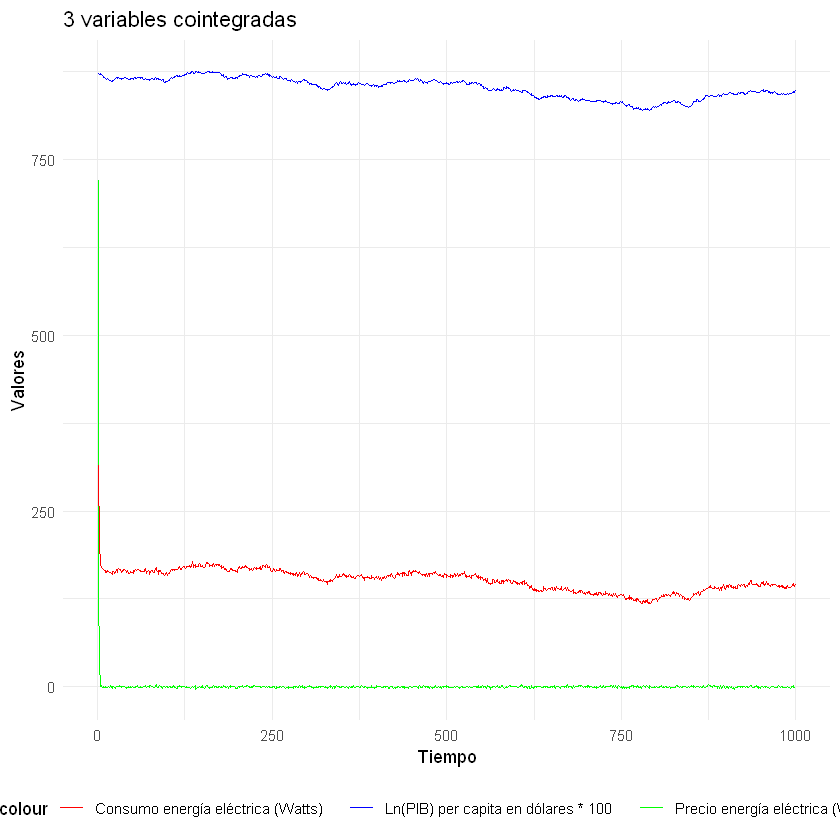

In [14]:
# Variables cointegradas
T = 1000                    # Número de datos

## Perturbaciones
set.seed(3579)
E1t = rnorm(n = T, mean = 0, sd = 1)
set.seed(2468)
EtX = rnorm(n = T, mean = 0, sd = 1)
set.seed(9462)
EtY = rnorm(n = T, mean = 0, sd = 1)

Ut = matrix(data = NA, nrow = T, ncol = 1)
X = matrix(data = NA, nrow = T, ncol = 1)
Y = matrix(data = NA, nrow = T, ncol = 1)
Z = matrix(data = NA, nrow = T, ncol = 1)

set.seed(1234)
Ut[1] = rnorm(n = 1, mean = 0, sd = 1)
X[1] = log(6104.14) * 100
Y[1] = 720

for (i in 2 : T){
    Ut[i] = 0.1 * Ut[i - 1] + E1t[i]
    Y[i] = 0.2 * Y[i - 1] + EtY[i]                    # Precio de la energía eléctrica (Watts)
    X[i] = X[i - 1] + EtX[i]                          # Ln(PIB) per capita de Colombia en 2021 en dólares * 100
    Z[i] = -700 + X[i] + Y[i] + Ut[i]                 # Consumo de energía eléctrica (Watts)
}

# Salidas
# Cargar la librería ggplot2
library(ggplot2)

# Crear un data frame con las tres variables
df <- data.frame(t = 1:T, X = X, Y = Y, Z = Z)

# Crear el gráfico de líneas utilizando ggplot2
ggplot(df, aes(x = t)) +
  geom_line(aes(y = X, color = "Ln(PIB) per capita en dólares * 100")) +
  geom_line(aes(y = Y, color = "Precio energía eléctrica (Watts)")) +
  geom_line(aes(y = Z, color = "Consumo energía eléctrica (Watts)")) +
  xlab("Tiempo") +
  ylab("Valores") +
  ggtitle("3 variables cointegradas") +
  scale_color_manual(values = c("red", "blue", "green")) +
  theme_minimal() + 
  theme(legend.position = "bottom")


## DGP[2]

In [ ]:
DGP.2 = function(Phi, Mu, Beta, Sigma_a, T, Zt_0, N_scenarios = 20, N_remove = 0, K.Dif = 3){
    DGP.2 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.2[1, ] = Zt_0
    t = c(1 : (T - 1))
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.2[i, j] = Mu + Beta * i + Phi * DGP.2[i - 1, j] + At[i]
        }
        # DGP.2[, j] = DGP.2[, j] - mean(DGP.2[, j])
    }
    if (N_remove == 0){
        Zt.2 = DGP.2
    } else {
        Zt.2 = DGP.2[-(1 : N_remove), ]
    }
    Zt.2 = data.frame(Zt.2)

    # Estabilización en nivel
    Est.Nivel = function(Data, K.Dif){
        X = Data
        # Operador de diferencia
        Diferencia = function(Data, K.Dif){                                 # Operador de diferencia
            Serie.dif = matrix(data = NA, nrow = (T - K.Dif), ncol = 1)
            for(i in 1: (T - K.Dif)){
                Serie.dif[i] <- Data[i + K.Dif] - Data[i]
            }
            return(Serie.dif)
        }

        # Matrix con los datos de J
        S = matrix(data = NA, nrow = (K.Dif + 1), ncol = 2)
        colnames(S) = c('J', 'S(J)')
        S[, 1] = seq(0, K.Dif, 1)
        for (i in 1 : K.Dif){
            # Diferenciación de la serie
            X.dif = matrix(data = NA, ncol = 1, nrow = (T - i))
            X.dif[, 1] = Diferencia(Data = X, K.Dif = i)

            # Cálculo de los S(j) diferenciadores (rezagados)
            S[1, 2] = round(sqrt((1 / (T - 0 - 1)) * sum((X - sum(X / (T - 0))) ** 2)), 6)                            # Diferenciación de J = 0
            S[(i + 1), 2] = round(sqrt((1 / (T - i - 1)) * sum((X.dif - sum(X.dif / (T - i))) ** 2)), 6)
        }

        # J óptimo (mínimo)
x   
    }
    
    Nt = length(Est.Nivel(Data = Zt.2[, 1], K.Dif = K.Dif) )
    Zt.f = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.f[, i] = Est.Nivel(Data = Zt.2[, i], K.Dif = K.Dif) 
    }
    Zt.f = data.frame(Zt.f)

    # Coeficientes
    T = Nt
    Coeff = matrix(data = NA, nrow = 3, ncol = N_scenarios)              # Nrow depende del DGP
    for (i in 1 : N_scenarios){
        Y = Zt.f[2 : T, i]
        X = cbind(1, (1 : (T - 1)), Zt.f[1 : (T - 1), i])
        Coeff[, i] = solve(t(X) %*% X) %*% t(X) %*% Y
    }
    Coeff = data.frame(t(Coeff))
    colnames(Coeff) = c('Mu', 'Beta', 'Phi')

    # Gráficas
    Coeff_Mu = ggplot(Coeff, aes(x = Mu)) + 
    labs(title = 'Histograma de Mu', x = 'Mu', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    Coeff_Phi = ggplot(Coeff, aes(x = Phi)) + 
    labs(title = 'Histograma de Phi', x = 'Phi', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    Coeff_Beta = ggplot(Coeff, aes(x = Beta)) + 
    labs(title = 'Histograma de Beta', x = 'Beta', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    # Salidas
    print(head(Coeff))
    print(Coeff_Mu / Coeff_Beta / Coeff_Phi)
    return(head(Zt.f))
}

DGP.2(Phi = 0.36, Mu = 40, Beta = 0.5, Sigma_a = 0.15, T = 240, Zt_0 = 1, N_scenarios = 200)

## DGP[3]

In [ ]:
DGP.3 = function(Sigma_a, T, Zt_0, N_scenarios = 20, N_remove = 0){
    DGP.3 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.3[1, ] = Zt_0
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.3[i, j] = DGP.3[i - 1, j] + At[i]
        }
        # DGP.3[, j] = DGP.3[, j] - mean(DGP.3[, j])
    }
    if (N_remove == 0){
        Zt.3 = DGP.3
    } else {
        Zt.3 = DGP.3[-(1 : N_remove), ]
    }
    Zt.3 = data.frame(Zt.3)

    # Estabilización en varianza
    Est.Var = function(Data, R = 12, Lambdas = c(-1, -0.5, 0, 0.5, 1)){
        X = Data
        T = length(X)

        # Función para verificar si un número es entero o no
        is.wholenumber <- function(x, tol = .Machine$double.eps ** 0.5)abs(x - round(x)) < tol             # TRUE = Entero, FALSE = Decimal

        # Redefinición de los datos
        X.r = matrix(data = X, nrow = 12)
        if (is.wholenumber(T / R) == 'FALSE'){
            H = floor(T / R)
            if (T > (H * R)){                                     # Llenar de NA los datos que se repiten al no ser múltiplo de R la matriz
                l = T - (H * R)
                X.r[((l + 1) : R), (H + 1)] = NA
            }
        } else if (is.wholenumber(T / R) == 'TRUE'){
            H = T / R
            X.r = matrix(data = X, nrow = R)
        }

        # Cálculo de las medias y desviaciones
        Zb = matrix(data = NA, ncol = H, nrow = 1)
        Zvar = matrix(data = NA, ncol = H, nrow = 1)
        for (i in 1 : H){
        Zb[i] = sum(X.r[, i]) / R
        Zvar[i] = sqrt((sum((X.r[, i] - Zb[i]) ** 2)) / (R - 1))
        }

        # Crear vector de lambdas
        Nlambdas = length(Lambdas)

        # Datos transformados
        Data.t = matrix(data = NA, ncol = Nlambdas, nrow = H)
        for (i in 1 : Nlambdas){
            for (j in 1 : H){
                Data.t[j, i] = Zvar[j] / (Zb[j] ** (1 - Lambdas[i])) 
            }
        }

        # Matriz con los datos de los lambas
        MLambda = matrix(data = NA, nrow = Nlambdas, ncol = 4)
        colnames(MLambda) = c("Lambda", "M (Lambda)","SD (Lambda)","CV (Lambda)")
        MLambda[, 1] = Lambdas

        for (i in 1 : Nlambdas){
        MLambda[i, 2] = mean(Data.t[, i])
        MLambda[i, 3] = sqrt((sum((Data.t[, i] - MLambda[i, 2]) ** 2)) / (H - 1))
        MLambda[i, 4] = MLambda[i, 3] / MLambda[i, 2]
        }

        # Lambda óptimo (mínimo)
        Opt = which.min(MLambda[, 4])                     # Número en que posición esta el mínimo 
        Lambda_opt = Lambdas[Opt]                         # Lambda óptimo

        # La transformación aplicada a los datos
        if (Lambda_opt == 0){
            X = log(X)
        } else {
            X = X ** Lambda_opt
        }
        # print(Lambda_opt)
    }

    Nt = length(Est.Var(Data = Zt.3[, 1]))
    Zt.f = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.f[, i] = Est.Var(Data = Zt.3[, i]) 
    }
    Zt.f = data.frame(Zt.f)

    # Coeficientes  
    T = Nt
    Coeff = matrix(data = NA, nrow = 1, ncol = N_scenarios)              # Nrow depende del DGP
    for (i in 1 : N_scenarios){
        Y = Zt.3[2 : T, i]
        X = cbind(Zt.3[1 : (T - 1), i])
        Coeff[, i] = solve(t(X) %*% X) %*% t(X) %*% Y
    }
    Coeff = data.frame(t(Coeff))
    colnames(Coeff) = c('Zt1')

    # Gráficas
    Coeff_Zt1 = ggplot(Coeff, aes(x = Zt1)) + 
    labs(title = 'Histograma de Zt - 1', x = 'Zt - 1', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.05, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    # Salidas
    print(head(Coeff))
    print(Coeff_Zt1)
    return(head(Zt.f))
}

DGP.3(Sigma_a = 0.15, T = 240, Zt_0 = 20, N_scenarios = 400)

## DGP[4]

In [ ]:
DGP.4 = function(Mu, Sigma_a, T, Zt_0, N_scenarios = 20, N_remove = 0, K.Dif = 3){
    DGP.4 = matrix(data = NA, nrow = T, ncol = N_scenarios)
    DGP.4[1, ] = Zt_0
    for (j in 1 : N_scenarios){
        set.seed(j)
        At = rnorm(n = T, mean = 0, sd = Sigma_a)
        for (i in 2 : T){
            DGP.4[i, j] = Mu + DGP.4[i - 1, j] + At[i]
        }
        # DGP.4[, j] = DGP.4[, j] - mean(DGP.4[, j])
    }
    if (N_remove == 0){
        Zt.4 = DGP.4
    } else {
        Zt.4 = DGP.4[-(1 : N_remove), ]
    }
    Zt.4 = data.frame(Zt.4)

    # Estabilización en varianza
    Est.Var = function(Data, R = 12, Lambdas = c(-1, -0.5, 0, 0.5, 1)){
        X = Data
        T = length(X)

        # Función para verificar si un número es entero o no
        is.wholenumber <- function(x, tol = .Machine$double.eps ** 0.5)abs(x - round(x)) < tol             # TRUE = Entero, FALSE = Decimal

        # Redefinición de los datos
        X.r = matrix(data = X, nrow = 12)
        if (is.wholenumber(T / R) == 'FALSE'){
            H = floor(T / R)
            if (T > (H * R)){                                     # Llenar de NA los datos que se repiten al no ser múltiplo de R la matriz
                l = T - (H * R)
                X.r[((l + 1) : R), (H + 1)] = NA
            }
        } else if (is.wholenumber(T / R) == 'TRUE'){
            H = T / R
            X.r = matrix(data = X, nrow = R)
        }

        # Cálculo de las medias y desviaciones
        Zb = matrix(data = NA, ncol = H, nrow = 1)
        Zvar = matrix(data = NA, ncol = H, nrow = 1)
        for (i in 1 : H){
        Zb[i] = sum(X.r[, i]) / R
        Zvar[i] = sqrt((sum((X.r[, i] - Zb[i]) ** 2)) / (R - 1))
        }

        # Crear vector de lambdas
        Nlambdas = length(Lambdas)

        # Datos transformados
        Data.t = matrix(data = NA, ncol = Nlambdas, nrow = H)
        for (i in 1 : Nlambdas){
            for (j in 1 : H){
                Data.t[j, i] = Zvar[j] / (Zb[j] ** (1 - Lambdas[i])) 
            }
        }

        # Matriz con los datos de los lambas
        MLambda = matrix(data = NA, nrow = Nlambdas, ncol = 4)
        colnames(MLambda) = c("Lambda", "M (Lambda)","SD (Lambda)","CV (Lambda)")
        MLambda[, 1] = Lambdas

        for (i in 1 : Nlambdas){
        MLambda[i, 2] = mean(Data.t[, i])
        MLambda[i, 3] = sqrt((sum((Data.t[, i] - MLambda[i, 2]) ** 2)) / (H - 1))
        MLambda[i, 4] = MLambda[i, 3] / MLambda[i, 2]
        }

        # Lambda óptimo (mínimo)
        Opt = which.min(MLambda[, 4])                     # Número en que posición esta el mínimo 
        Lambda_opt = Lambdas[Opt]                         # Lambda óptimo

        # La transformación aplicada a los datos
        if (Lambda_opt == 0){
            X = log(X)
        } else {
            X = X ** Lambda_opt
        }
        # print(Lambda_opt)
    }

    Nt = length(Est.Var(Data = Zt.4[, 1]))
    Zt.v = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.v[, i] = Est.Var(Data = Zt.4[, i]) 
    }
    Zt.v = data.frame(Zt.v)

    # Estabilización en nivel
    Est.Nivel = function(Data, K.Dif){
        X = Data
        T = length(X)
        # Operador de diferencia
        Diferencia = function(Data, K.Dif){                                 # Operador de diferencia
            Serie.dif = matrix(data = NA, nrow = (T - K.Dif), ncol = 1)
            for(i in 1: (T - K.Dif)){
                Serie.dif[i] <- Data[i + K.Dif] - Data[i]
            }
            return(Serie.dif)
        }

        # Matrix con los datos de J
        S = matrix(data = NA, nrow = (K.Dif + 1), ncol = 2)
        colnames(S) = c('J', 'S(J)')
        S[, 1] = seq(0, K.Dif, 1)
        for (i in 1 : K.Dif){
            # Diferenciación de la serie
            X.dif = matrix(data = NA, ncol = 1, nrow = (T - i))
            X.dif[, 1] = Diferencia(Data = X, K.Dif = i)

            # Cálculo de los S(j) diferenciadores (rezagados)
            S[1, 2] = round(sqrt((1 / (T - 0 - 1)) * sum((X - sum(X / (T - 0))) ** 2)), 6)                            # Diferenciación de J = 0
            S[(i + 1), 2] = round(sqrt((1 / (T - i - 1)) * sum((X.dif - sum(X.dif / (T - i))) ** 2)), 6)
        }

        # J óptimo (mínimo)
        Opt = which.min(S[, 2])                     # Número en que posición esta el mínimo 
        J_opt = S[Opt, 1]                           # Número de diferencias aplicadas a la serie

        # La transformación aplicada a los datos
        X = Diferencia(Data = X, K.Dif = J_opt)
    }
    
    Nt = length(Est.Nivel(Data = Zt.v[, 1], K.Dif = K.Dif))
    Zt.f = matrix(data = NA, nrow = Nt, ncol = N_scenarios)
    for (i in 1 : N_scenarios){
        Zt.f[, i] = Est.Nivel(Data = Zt.v[, i], K.Dif = K.Dif) 
    }
    Zt.f = data.frame(Zt.f)

    # Coeficientes
    T = Nt
    Coeff = matrix(data = NA, nrow = 2, ncol = N_scenarios)              # Nrow depende del DGP
    for (i in 1 : N_scenarios){
        Y = Zt.4[2 : T, i]
        X = cbind(1, Zt.4[1 : (T - 1), i])
        Coeff[, i] = solve(t(X) %*% X) %*% t(X) %*% Y
    }
    Coeff = data.frame(t(Coeff))
    colnames(Coeff) = c('Mu', 'Zt1')

    # Gráficas
    Coeff_Mu = ggplot(Coeff, aes(x = Mu)) + 
    labs(title = 'Histograma de Mu', x = 'Mu', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    Coeff_Zt1 = ggplot(Coeff, aes(x = Zt1)) + 
    labs(title = 'Histograma de Zt - 1', x = 'Zt - 1', y = 'Densidad') +
    geom_histogram(aes(y = ..density..), colour = 'darkblue', fill = 'lightblue', alpha = 0.5, bins = N_scenarios / 4) +
    geom_density(alpha = 0.2, fill = "#FF6666")

    # Salidas
    print(head(Coeff))
    print(Coeff_Mu / Coeff_Zt1)
    return(head(Zt.f))
}

DGP.4(Mu = 20, Sigma_a = 0.15, Zt_0 = 1, N_scenarios = 400, T = 240)

# Tarea 2 - Impulso respuesta

In [ ]:
Escenarios<-100
N<-200
M<-2
de<-1
X0<-50
obs.eliminadas<-5
corte = 2
bin<-0.005

Dif<-matrix(data=NA,ncol=Escenarios,nrow=N)

for (k in 1:Escenarios) {
  
    phi<-(k/Escenarios)
    
    set.seed(1)
    a<-rnorm(N,mean=0,sd=de)
    Z.og<-matrix(data=NA,ncol=1,nrow=N)
    Z.og[1]<-X0
    for (i in 2:N) {
    Z.og[i]<-M+(phi*Z.og[i-1])+a[i]
    }

    #Serie de impulso

    X.choque<-Z.og[corte-1]*2
    corte = obs.eliminadas
    Z<-matrix(data=NA,ncol=1,nrow=N)
    Z[1]<-X0
    for (i in 2:(corte-1)) {
    Z[i]<-M+(phi*Z[i-1])+a[i]
    }
    corte<-obs.eliminadas
    Z[obs.eliminadas]<-X.choque
    for (i in (corte+1):N) {
    Z[i]<-M+(phi*Z[i-1])+a[i]
    }
    #ZZ[1:length(Z),k]<-Z
    #ZZ.og[1:length(Z),k]<-Z.og
    Dif[1:length(Z),k]<-as.matrix((Z-Z.og))
}

DF<-as.data.frame(Dif)
DF.1 <- data.frame(x = seq_along(DF[, 1]), DF)
DF.2 <- melt(DF.1, id.vars = "x")
ggplot(DF.2, aes(x = x, y = value, color = variable)) + 
  geom_line(linetype = 1,lwd = 0.1, show.legend = FALSE) +
  xlab("Periodo") + ylab("Valor") + ggtitle("Impulso-respuesta")



# Distribuciones Dickey Fuller

## Tao

In [ ]:
#Creando la función
Tau <- function(T, S, Z_0 = 0, Sigma_a = 1){
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial
  
  #Creando una matriz vacía para almacenar los estadísticos
  Tau = c()
  
  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[1]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 1))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[1, 1])
    
    #Llenando la matriz
    Tau[n] <- Gamma / Gamma_std
  }
  # Quantiles
  Q = matrix(data = c(quantile(Tau, probs = 0.1), quantile(Tau, probs = 0.05), quantile(Tau, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q) = c('10%', '5%', '1%')

  # Gráficas
  # print(G_Tau)
  Den = density(Tau)
  value2 = Q[, 1]
  value3 = Q[, 2]
  value4 = Q[, 3]
  plot(Den, main = sprintf('Dist. Tau con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
  legend(x= "topright" , legend = c("Alfa = 0.1", Q[, 1], "Alfa = 0.05", Q[, 2], "Alfa = 0.01", Q[, 3]))
  polygon(c(Den$x[Den$x <= value2], value2),
      c(Den$y[Den$x <= value2], 0),
      col = rgb(0, 1, 0, alpha = 0.2),
      border = 1)
  polygon(c(Den$x[Den$x <= value3], value3),
    c(Den$y[Den$x <= value3], 0),
    col = rgb(0, 1, 0, alpha = 0.2),
    border = 1)
  polygon(c(Den$x[Den$x <= value4], value4),
      c(Den$y[Den$x <= value4], 0),
      col = rgb(0, 1, 0, alpha = 0.2),
      border = 1)
  abline(v = mean(Tau), col = "green", lwd = 3, lty = 2)
}
Tau(T = 1000, S = 10000)

## Tao ~ Mu

In [ ]:
#Creando la función
Tau_M <- function(T, S, Z_0 = 0, Sigma_a = 1){
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial
  
  #Creando una matriz vacía para almacenar los estadísticos
  Tau_M = c()
  
  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(1, X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[2]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 2))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[2, 2])
    
    #Llenando la matriz
    Tau_M[n] <- Gamma / Gamma_std
  }
  # Quantiles
  Q = matrix(data = c(quantile(Tau_M, probs = 0.1), quantile(Tau_M, probs = 0.05), quantile(Tau_M, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q) = c('10%', '5%', '1%')

  # Gráficas
  # print(G_Tau_M)
  Den = density(Tau_M)
  value2 = Q[, 1]
  value3 = Q[, 2]
  value4 = Q[, 3]
  plot(Den, main = sprintf('Dist. Tau ~ Mu con %s datos y %s escenarios', T, S), xlab="Estadístico Tau - Mu", ylab="Densidad", col="black", lty=1, lwd=4)
  legend(x= "topright" , legend = c("Alfa = 0.1", Q[, 1], "Alfa = 0.05", Q[, 2], "Alfa = 0.01", Q[, 3]))
  polygon(c(Den$x[Den$x <= value2], value2),
      c(Den$y[Den$x <= value2], 0),
      col = rgb(0, 0, 1, alpha = 0.2),
      border = 1)
  polygon(c(Den$x[Den$x <= value3], value3),
    c(Den$y[Den$x <= value3], 0),
    col = rgb(0, 0, 1, alpha = 0.2),
    border = 1)
  polygon(c(Den$x[Den$x <= value4], value4),
      c(Den$y[Den$x <= value4], 0),
      col = rgb(0, 0, 1, alpha = 0.2),
      border = 1)
  abline(v = mean(Tau_M), col = "blue", lwd = 3, lty = 2)
}
Tau_M(T = 1000, S = 10000)

## Tao ~ Tao

In [ ]:
#Creando la función
Tau_T <- function(T, S, Z_0 = 0, Sigma_a = 1){
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial
  
  #Creando una matriz vacía para almacenar los estadísticos
  Tau_T = c()
  
  for (n in 1 : S){
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[1 : (T - 1)]
    
    #Estimando la regresión (OLS)
    Y = X.Diff
    X = cbind(1, c(1 : (T - 1)), X.Rez)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)
    Gamma = Coeff[3]                                               # Coeficiente Gamma estimado

    # Estimación sigma^2 (Beta moño de OLS)
    Ym = X %*% Coeff
    Em = Y - Ym
    Sigma2 = as.numeric((t(Em) %*% Em) / (T - 3))
    Var.cov = (Sigma2 * solve(t(X) %*% X))
    Gamma_std = sqrt(Var.cov[3, 3])
    
    #Llenando la matriz
    Tau_T[n] <- Gamma / Gamma_std
  }

  # Gráficas
  # Tau_T1 = data.frame(Tau_T)
  # G_Tau_T = ggplot(Tau_T1, aes(x = Tau_T)) + 
  #     labs(title = sprintf('Dist. Tau ~ T con %s datos y %s escenarios', T, S), x = 'Tau ~ T', y = 'Densidad') +
  #     geom_density(color = 'black', fill = 'red', alpha = 0.09) + 
  #     geom_vline(aes(xintercept= mean(Tau_T)), color = "blue", linetype = "dashed", size = 0.7)

  # Quantiles
  Q = matrix(data = c(quantile(Tau_T, probs = 0.1), quantile(Tau_T, probs = 0.05), quantile(Tau_T, probs = 0.01)), ncol = 3, nrow = 1)
  colnames(Q) = c('10%', '5%', '1%')

  # Gráficas
  # print(G_Tau_T)
  Den = density(Tau_T)
  value2 = Q[, 1]
  value3 = Q[, 2]
  value4 = Q[, 3]
  plot(Den, main = sprintf('Dist. Tau ~ T con %s datos y %s escenarios', T, S), xlab = "Estadístico Tau - Tau", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
  legend(x= "topright" , legend = c("Alfa = 0.1", Q[, 1], "Alfa = 0.05", Q[, 2], "Alfa = 0.01", Q[, 3]))
  polygon(c(Den$x[Den$x <= value2], value2),
      c(Den$y[Den$x <= value2], 0),
      col = rgb(1, 0, 0, alpha = 0.2),
      border = 1)
  polygon(c(Den$x[Den$x <= value3], value3),
    c(Den$y[Den$x <= value3], 0),
    col = rgb(1, 0, 0, alpha = 0.2),
    border = 1)
  polygon(c(Den$x[Den$x <= value4], value4),
      c(Den$y[Den$x <= value4], 0),
      col = rgb(1, 0, 0, alpha = 0.2),
      border = 1)
  abline(v = mean(Tau_T), col = "red", lwd = 3, lty = 2)
}
Tau_T(T = 100, S = 1000)

## Phi_1

In [ ]:
#Creando la función
Phi_1 <- function(T, S, P, Z_0 = 0, Sigma_a = 1){
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial
  
  #Creando una matriz vacía para almacenar los estadísticos
  Phi_1 = matrix(data = NA, nrow = S, ncol = 1)
  
  for (n in 1 : S){    
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[2 : T]
    
    # Matriz delta
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
          X.d.r = X.Diff[(T - (T - j)) : T]
          Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    #Estimando la regresión (OLS) modelo no restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(1, X.Rez[1 : (T - P)], Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_nr = as.numeric((t(Em) %*% Em))

    #Estimando la regresión (OLS) modelo restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_r = as.numeric((t(Em) %*% Em))
    
    # #Llenando la matriz
    Phi_1[n] = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

  }

  # Quantiles
  Q = matrix(data = c(quantile(Phi_1, probs = 0.9), quantile(Phi_1, probs = 0.95), quantile(Phi_1, probs = 0.99)), ncol = 3, nrow = 1)
  colnames(Q) = c('90%', '95%', '99%')

  # Gráficas
  # print(G_Tau_T)
  Den = density(Phi_1)
  value2 = Q[, 1]
  value3 = Q[, 2]
  value4 = Q[, 3]
  plot(Den, main = sprintf('Dist. Phi1 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_1", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
  legend(x= "topright" , legend = c("Alfa = 0.1", Q[, 1], "Alfa = 0.05", Q[, 2], "Alfa = 0.01", Q[, 3]))
  polygon(c(Den$x[Den$x >= value2], value2),
      c(Den$y[Den$x >= value2], 0),
      col = rgb(1, 1, 0, alpha = 0.2),
      border = 1)
  polygon(c(Den$x[Den$x >= value3], value3),
    c(Den$y[Den$x >= value3], 0),
    col = rgb(1, 1, 0, alpha = 0.2),
    border = 1)
  polygon(c(Den$x[Den$x >= value4], value4),
      c(Den$y[Den$x >= value4], 0),
      col = rgb(1, 1, 0, alpha = 0.2),
      border = 1)
  abline(v = mean(Phi_1), col = rgb(1, 1, 0), lwd = 3, lty = 2)
}

Phi_1(T = 1000, S = 1000, P = 7)

## Phi_2

In [ ]:
# Creando la función
Phi_2 <- function(T, S, P, Z_0 = 0, Sigma_a = 1){
  Zt <- c(Z_0)                                                    # Creando matriz con el valor inicial
  
  # Creando una matriz vacía para almacenar los estadísticos
  Phi_2 = matrix(data = NA, nrow = S, ncol = 1)
  
  for (n in 1 : S){    
    # Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    # Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    # Calculando la serie diferenciada
    Diferencia = function(Data){                                  # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    # Calculando la serie rezagada
    X.Rez <- Zt[2 : T]
    
    # Matriz delta
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P  - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
          X.d.r = X.Diff[(T - (T - j)) : T]
          Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    # Estimando la regresión (OLS) modelo no restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(1, c(1 : (T - P)), X.Rez[1 : (T - P)], Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_nr = as.numeric((t(Em) %*% Em))

    # Estimando la regresión (OLS) modelo restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_r = as.numeric((t(Em) %*% Em))
    
    # Llenando la matriz
    Phi_2[n] = ((SRC_r -  SRC_nr) / (3)) / ((SRC_nr) / (T - 3 - (P - 1))) 

  }

  # Quantiles
  Q = matrix(data = c(quantile(Phi_2, probs = 0.9), quantile(Phi_2, probs = 0.95), quantile(Phi_2, probs = 0.99)), ncol = 3, nrow = 1)
  colnames(Q) = c('90%', '95%', '99%')

  # Gráficas
  # print(G_Tau_T)
  Den = density(Phi_2)
  value2 = Q[, 1]
  value3 = Q[, 2]
  value4 = Q[, 3]
  plot(Den, main = sprintf('Dist. Phi2 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_2", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
  legend(x= "topright" , legend = c("Alfa = 0.1", Q[, 1], "Alfa = 0.05", Q[, 2], "Alfa = 0.01", Q[, 3]))
  polygon(c(Den$x[Den$x >= value2], value2),
      c(Den$y[Den$x >= value2], 0),
      col = rgb(1, 0, 1, alpha = 0.2),
      border = 1)
  polygon(c(Den$x[Den$x >= value3], value3),
    c(Den$y[Den$x >= value3], 0),
    col = rgb(1, 0, 1, alpha = 0.2),
    border = 1)
  polygon(c(Den$x[Den$x >= value4], value4),
      c(Den$y[Den$x >= value4], 0),
      col = rgb(1, 0, 1, alpha = 0.2),
      border = 1)
  abline(v = mean(Phi_2), col = rgb(1, 0, 1), lwd = 3, lty = 2)
}
Phi_2(T = 1000, S = 1000, P = 7)

## Phi_3

In [ ]:
#Creando la función
Phi_3 <- function(T, S, P, Z_0 = 0, Sigma_a = 1){
  Zt <- c(Z_0)                                                    #Creando matriz con el valor inicial
  
  #Creando una matriz vacía para almacenar los estadísticos
  Phi_3 = matrix(data = NA, nrow = S, ncol = 1)
  
  for (n in 1 : S){    
    #Generando los errores
    set.seed(n)
    At <- rnorm(n = T ,mean = 0, sd = Sigma_a)

    #Corriendo la función generadora del PGD
    for(t in 2 : T){
      Zt[t] = Zt[t - 1] + At[t]
    }

    #Calculando la serie diferenciada
    Diferencia = function(Data){                                 # Operador de diferencia
        Serie.dif = matrix(data = NA, nrow = (T - 1), ncol = 1)
        for(i in 1 : (T - 1)){
            Serie.dif[i] <- Data[i + 1] - Data[i]
        }
        return(Serie.dif)
    }
    X.Diff = Diferencia(Data = Zt)

    #Calculando la serie rezagada
    X.Rez <- Zt[2 : T]
    
    # Matriz delta
    Delta_P = matrix(data = NA, nrow = (T - 1), ncol = (P  - 1))
    for(i in 1 : (T - 1)){
        for(j in 2 : P){
          X.d.r = X.Diff[(T - (T - j)) : T]
          Delta_P[i, (j - 1)] = X.d.r[i]
        }
    }
    Delta_P = Delta_P[-((T - P + 1) : T), ]
    
    #Estimando la regresión (OLS) modelo no restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(c(1 : (T - P)), X.Rez[1 : (T - P)], Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_nr = as.numeric((t(Em) %*% Em))

    #Estimando la regresión (OLS) modelo restringido
    Y = X.Diff[1 : (T - P)]
    X = cbind(Delta_P)
    Coeff = solve(t(X) %*% X) %*% (t(X) %*% Y)

    # Estimación SRC_nr
    Ym = X %*% Coeff
    Em = Y - Ym
    SRC_r = as.numeric((t(Em) %*% Em))
    
    # #Llenando la matriz
    Phi_3[n] = ((SRC_r -  SRC_nr) / (2)) / ((SRC_nr) / (T - 2 - (P - 1))) 

  }

  # Quantiles
  Q = matrix(data = c(quantile(Phi_3, probs = 0.9), quantile(Phi_3, probs = 0.95), quantile(Phi_3, probs = 0.99)), ncol = 3, nrow = 1)
  colnames(Q) = c('90%', '95%', '99%')

  # Gráficas
  # print(G_Tau_T)
  Den = density(Phi_3)
  value2 = Q[, 1]
  value3 = Q[, 2]
  value4 = Q[, 3]
  plot(Den, main = sprintf('Dist. Phi3 con %s datos, %s escenarios y con un P de %s', T, S, P), xlab = "Estadístico Phi_3", ylab = "Densidad", col = "black", lty = 1, lwd = 4)
  legend(x= "topright" , legend = c("Alfa = 0.1", Q[, 1], "Alfa = 0.05", Q[, 2], "Alfa = 0.01", Q[, 3]))
  polygon(c(Den$x[Den$x >= value2], value2),
      c(Den$y[Den$x >= value2], 0),
      col = rgb(0, 1, 1, alpha = 0.2),
      border = 1)
  polygon(c(Den$x[Den$x >= value3], value3),
    c(Den$y[Den$x >= value3], 0),
    col = rgb(0, 1, 1, alpha = 0.2),
    border = 1)
  polygon(c(Den$x[Den$x >= value4], value4),
      c(Den$y[Den$x >= value4], 0),
      col = rgb(0, 1, 1, alpha = 0.2),
      border = 1)
  abline(v = mean(Phi_3), col = rgb(0, 1, 1), lwd = 3, lty = 2)
}
Phi_3(T = 1000, S = 1000, P = 7)